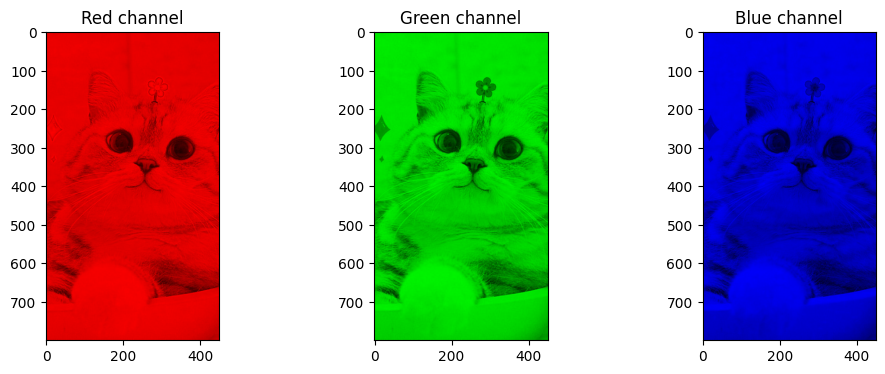

In [ ]:
import numpy as np
import imageio.v2 as iio
import matplotlib.pylab as plt


# Đọc file
img = iio.imread('cat.jpg')

# Tạo 3 ảnh trống
red_img = np.zeros_like(img)
green_img = np.zeros_like(img)
blue_img = np.zeros_like(img)

#Tách các kênh màu
red_img[:,:,0] = img[:,:,0] # red
green_img[:,:,1] = img[:,:,1] # green
blue_img[:,:,2] = img[:,:,2] # blue

# Ghi các ảnh đã tách kênh màu
iio.imwrite('cat_red.jpg', red_img)
iio.imwrite('cat_green.jpg', green_img)
iio.imwrite('cat_blue.jpg', blue_img)

# Hiển thị các ảnh tách bằng thư viện matplotlib.pylab (Tạo ra 1 hàng , 3 cột)
fix, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(red_img)
axs[0].set_title('Red channel')
axs[1].imshow(green_img)
axs[1].set_title('Green channel')
axs[2].imshow(blue_img)
axs[2].set_title('Blue channel')
  
plt.show()

In [ ]:
import numpy as np
import imageio.v2 as iio

# Đọc file
img = iio.imread('cat.jpg')
# Tráo đổi cách kênh màu (0 là red , 1 là blue , 2 green)
# Sau đấy là ghi các file thành 1 tên khác và lưu vào máy
img_grb = img[:,:,[1,0,2]]
iio.imwrite('cat_grb.jpg', img_grb)

img_rbg = img[:,:,[0,2,1]]
iio.imwrite('cat_rbg.jpg', img_rbg)

img_brg = img[:,:,[2,0,1]]
iio.imwrite('cat_brg.jpg', img_brg)

# thông báo
print("Đã lưu 3 ảnh vào máy")

Đã lưu 3 ảnh vào máy


Text(0.5, 1.0, 'Value title')

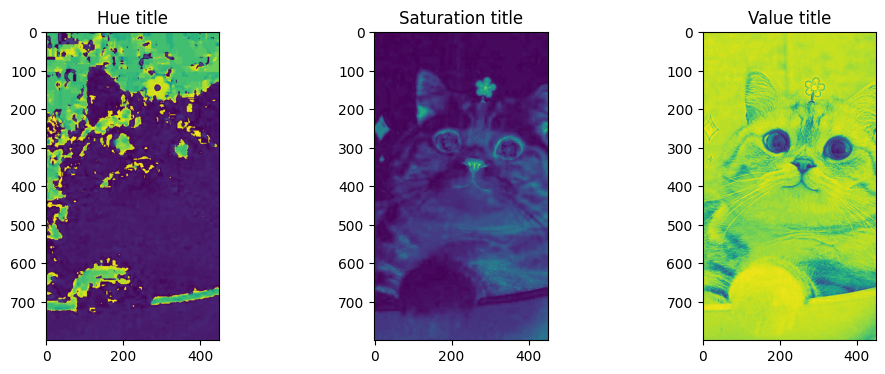

In [ ]:
import numpy as np
import imageio.v2 as iio
import matplotlib.pylab as plt
import colorsys

# Đọc file
rgb = iio.imread('cat.jpg')

# chuyển hoá ảnh
rgb_norm = rgb / 255.0

# Chuyển đổi RGB -> HSV
rgb2hsv = np.vectorize(colorsys.rgb_to_hsv)

h, s, v = rgb2hsv(rgb_norm[:,:,0], rgb_norm[:,:,1], rgb_norm[:,:,2])

# Chuyển hsv về ảnh grayscale (Trắng đen)
h_img = (h*255).astype(np.uint8)
s_img = (s*255).astype(np.uint8)
v_img = (v*255).astype(np.uint8)

# Ghi ảnh lưu vào máy
iio.imwrite('cat_hue.jpg', h_img)

iio.imwrite('cat_saturation.jpg', s_img)

iio.imwrite('cat_value.jpg', v_img)

# Hiển thị các ảnh tách bằng thư viện matplotlib.pylab (Tạo ra 1 hàng , 3 cột)
fix, axs = plt.subplots(1, 3, figsize=(12,4))

axs[0].imshow(h_img)
axs[0].set_title("Hue title")
axs[1].imshow(s_img)
axs[1].set_title("Saturation title")
axs[2].imshow(v_img)
axs[2].set_title("Value title")




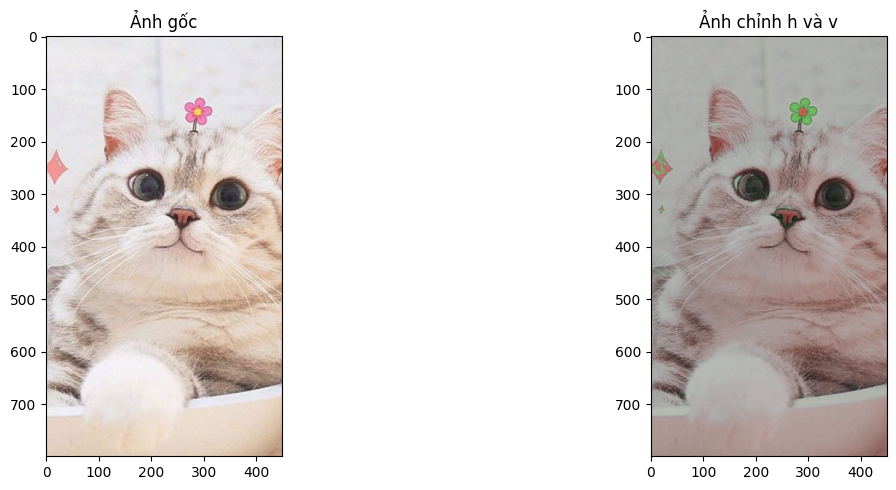

In [3]:
import numpy as np
import imageio.v2 as iio
import matplotlib.pylab as plt
import colorsys

#Đọc ảnh
rgb = iio.imread("cat.jpg")

# chuyển hoá ảnh
rgb_norm = rgb / 255.0

# Chuyển đổi RGB -> HSV
rgb2hsv = np.vectorize(colorsys.rgb_to_hsv)
h, s, v = rgb2hsv(rgb_norm[:,:,0], rgb_norm[:,:,1], rgb_norm[:,:,2])

# Điều chỉnh h (hue) và v (value)
h_new = h / 3.0
v_new = v * 0.75

# Chuyển ngược HSV -> RGB
hsv2rgb = np.vectorize(colorsys.hsv_to_rgb)
r_new , g_new , b_new = hsv2rgb(h_new,s,v_new)

# Gộp lại và chuyển về dạng ảnh uint8
rgb_new = np.stack([r_new, g_new, b_new], axis=2)
rgb_new = (rgb_new * 255).astype(np.uint8)

# Ghi ảnh lưu vào máy
iio.imwrite('cat_modified.jpg', rgb_new)

# Hiển thị ảnh
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(rgb_norm)
plt.title("Ảnh gốc")

plt.subplot(1,2,2)
plt.imshow(rgb_new)
plt.title("Ảnh chỉnh h và v")

plt.tight_layout()
plt.show()


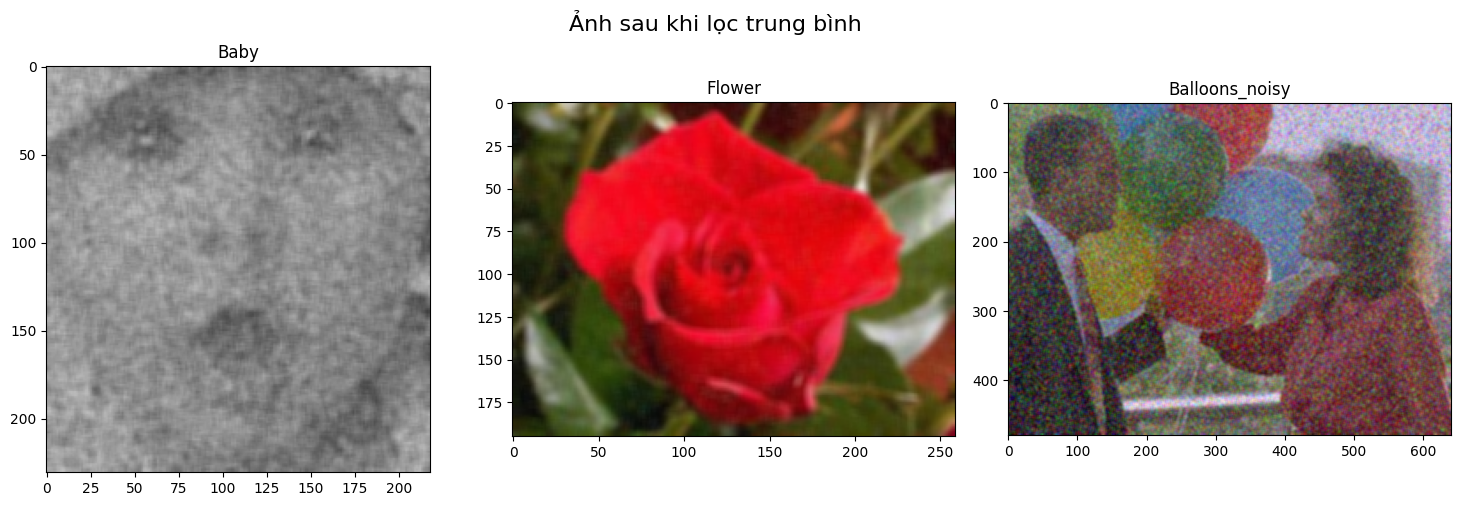

In [ ]:
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
import colorsys
# Đọc ảnh
a1 = iio.imread('baby.jpeg')
a2 = iio.imread('flower.jpeg')
a3 = iio.imread('balloons_noisy.png')

# Tạo kernel lọc trung bình 5x5
k = np.ones((5,5)) / 25

# Áp dụng lọc trung bình cho từng ảnh và từng kênh màu
b1 = np.zeros_like(a1)
for i in range(3):  
    b1[..., i] = ndimage.convolve(a1[..., i], k)

b2 = np.zeros_like(a2)
for i in range(3):  
    b2[..., i] = ndimage.convolve(a2[..., i], k)

b3 = np.zeros_like(a3)
for i in range(3):  
    b3[..., i] = ndimage.convolve(a3[..., i], k)


# Lưu ảnh đã lọc
iio.imsave('baby_mean_filler.jpeg', b1)
iio.imsave('flower_mean_filler.jpeg', b2)
iio.imsave('balloons_noisy_mean_filler.png', b3)


# Hiện thị ảnh 
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(b1.astype(np.uint8))
plt.title('Baby')

plt.subplot(1,3,2)
plt.imshow(b2.astype(np.uint8))
plt.title('Flower')

plt.subplot(1,3,3)
plt.imshow(b3.astype(np.uint8))
plt.title('Balloons_noisy')

plt.suptitle("Ảnh sau khi lọc trung bình", fontsize=16)
plt.tight_layout()
plt.show()

